In [1]:
import json

#### Read Google Dataset

In [2]:
factuality_data = json.load(open('../Dataset/xsum_hallucination_annotations/factuality_annotations_xsum_summaries.json'))
hallucination_data = json.load(open('../Dataset/xsum_hallucination_annotations/hallucination_annotations_xsum_summaries.json'))

In [3]:
print(len(factuality_data))
print(len(hallucination_data))

5597
11185


In [4]:
factuality_data[0]

{'bbcid': 29911712,
 'system': 'BERTS2S',
 'summary': 'more than 50 pupils at a bristol academy have been sent home from school because of a lack of uniform.',
 'is_factual': 'no',
 'worker_id': 'wid_0'}

In [5]:
hallucination_data[0]

{'bbcid': 34687720,
 'system': 'BERTS2S',
 'summary': 'rory mcilroy will take a one-shot lead into the final round of the wgc-hsbc champions after carding a three-under',
 'hallucination_type': 'extrinsic',
 'hallucinated_span': 'rory mcilroy will take a one-shot lead into the final round of the wgc-hsbc champions after carding a three-under',
 'worker_id': 'wid_0'}

#### 

#### Read Calculated Probability

In [6]:
google_data_with_proba = json.load(open('google_data_with_proba_LM.json'))

In [7]:
print(len(google_data_with_proba))

500


In [8]:
google_data_with_proba['34687720']['Gold']

{'summary': 'rory mcilroy moved to within a shot of joint leaders victor dubuisson and jaco van zyl after the third round of the turkish airlines open.',
 'summary_upper': 'Rory McIlroy moved to within a shot of joint leaders Victor Dubuisson and Jaco van Zyl after the third round of the Turkish Airlines open .',
 'ents': [{'start': 0,
   'end': 4,
   'label': -1,
   'type': 'PERSON',
   'ent': 'Rory',
   'prior': 0.380859375,
   'posterior': 0.65087890625},
  {'start': 5,
   'end': 12,
   'label': -1,
   'type': 'PERSON',
   'ent': 'McIlroy',
   'prior': 0.9189453125,
   'posterior': 0.806640625},
  {'start': 53,
   'end': 59,
   'label': -1,
   'type': 'PERSON',
   'ent': 'Victor',
   'prior': 0.0023136138916015625,
   'posterior': 0.00011754035949707031},
  {'start': 60,
   'end': 69,
   'label': -1,
   'type': 'PERSON',
   'ent': 'Dubuisson',
   'prior': 0.97119140625,
   'posterior': 0.78466796875},
  {'start': 74,
   'end': 78,
   'label': -1,
   'type': 'PERSON',
   'ent': 'Jaco

#### Claculate Factuality Correlation

In [9]:
factuality_data[1]

{'bbcid': 29911712,
 'system': 'BERTS2S',
 'summary': 'more than 50 pupils at a bristol academy have been sent home from school because of a lack of uniform.',
 'is_factual': 'no',
 'worker_id': 'wid_1'}

In [10]:
factuality = {}
for i, f in enumerate(factuality_data):
    if f['bbcid'] not in factuality:
        factuality[f['bbcid']] = {}
    if f['system'] not in factuality[f['bbcid']]:
        factuality[f['bbcid']][f['system']] = []
        
    if f['is_factual'] == 'yes':
        factuality[f['bbcid']][f['system']].append(True)
    elif f['is_factual'] == 'no':
        factuality[f['bbcid']][f['system']].append(False)
    elif f['is_factual'] is None:
        factuality[f['bbcid']][f['system']].append(False)
    else:
        print(i)
        raise Exception('Unkown Label: {}'.format(f['is_factual']))

In [11]:
hallucination = {}
for h in hallucination_data:
    if h['bbcid'] not in hallucination:
        hallucination[h['bbcid']] = {}
    if h['system'] not in hallucination[h['bbcid']]:
        hallucination[h['bbcid']][h['system']] = []
    
    if h['hallucination_type'] == 'extrinsic' and len(h['hallucinated_span']) < len(h['summary']):
        hallucination[h['bbcid']][h['system']].append(h['hallucinated_span'])

In [12]:
# entity in hallucination span (extrinsic), and summary false: false-hallucination
# entity in hallucination span (extrinsic), and summary true: true-hallucnination
# entity not in hallucination span and summary true: non-hallucination

In [13]:
google_data_with_proba['34687720']['BERTS2S']

{'summary': 'rory mcilroy will take a one-shot lead into the final round of the wgc-hsbc champions after carding a three-under',
 'summary_upper': 'Rory McIlroy will take a one-shot lead into the final round of the Wgc-Hsbc champions after carding a Three-Under',
 'ents': [{'start': 0,
   'end': 4,
   'label': 2,
   'type': 'PERSON',
   'ent': 'Rory',
   'prior': 0.379150390625,
   'posterior': 0.6513671875},
  {'start': 5,
   'end': 12,
   'label': 2,
   'type': 'PERSON',
   'ent': 'McIlroy',
   'prior': 0.97119140625,
   'posterior': 0.80712890625},
  {'start': 25,
   'end': 28,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'one',
   'prior': 0.004116058349609375,
   'posterior': 0.400146484375},
  {'start': 63,
   'end': 75,
   'label': 2,
   'type': 'ORG',
   'ent': 'the Wgc-Hsbc',
   'prior': 0.0,
   'posterior': 0.0},
  {'start': 102,
   'end': 107,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'Three',
   'prior': 1.138448715209961e-05,
   'posterior': 2.3603439331054688e-05

In [14]:
factuality[34687720]['BERTS2S']

[False, False, False]

In [15]:
hallucination[34687720]['BERTS2S']

['the final round of the wgc-hsbc champions']

#### Evaluating

In [16]:
from utils_google_evaluation import read_document

In [17]:
def check_factual(scores):
    if None in scores: return False
#     if len(scores) == sum(scores):
#         return True
#     else:
#         return False

    if sum(scores) * 2 >= len(scores):
        return True
    else:
        return False

In [18]:
def check_hallucinated(entity, spans):
    for s in spans:
        if entity in s:
            return True
    return False

In [19]:
factual_label, hallucination_label, posterior_label = [], [], []
prior_probs, posterior_probs = [], []
overlap_preds, threshold_preds = [], []

for bbcid in google_data_with_proba:
    for system in google_data_with_proba[bbcid]:
        if int(bbcid) not in factuality or system not in factuality[int(bbcid)]: continue
    
        for e in google_data_with_proba[bbcid][system]['ents']:
            if 'posterior' not in e or e['posterior'] is None: continue
            
            is_factual = check_factual(factuality[int(bbcid)][system])
            is_hallucinated = check_hallucinated(e['ent'], hallucination[int(bbcid)][system])

            if is_factual and is_hallucinated:
                factual_label.append(1)
                hallucination_label.append(1)
            elif is_factual and not is_hallucinated:
                factual_label.append(1)
                hallucination_label.append(0)
            elif (not is_factual) and is_hallucinated:
                factual_label.append(0)
                hallucination_label.append(1)
            elif (not is_factual) and (not is_hallucinated):
                factual_label.append(1)
                hallucination_label.append(0)
            else:
                continue
            
            prior_probs.append(e['prior'])
            posterior_probs.append(e['posterior'])
            
            if e['posterior'] > e['prior']:
                posterior_label.append(1)
            else:
                posterior_label.append(0)
                
            if e['ent'].lower() in read_document(int(bbcid)).lower():
                overlap_preds.append(1)
            else:
                overlap_preds.append(0)
                
            if e['posterior'] > 0.4:
                threshold_preds.append(1)
            else:
                threshold_preds.append(0)

In [20]:
print(len(factual_label))
assert len(factual_label) == len(posterior_label)

5506


#### Draw Diagram

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt

In [22]:
prior_posterior = []
for x, y, z, h in zip(posterior_probs, prior_probs, factual_label, hallucination_label):
    my_label = -1
    if z == 1 and h == 1:
        my_label = 1
    elif z == 0 and h == 1:
        my_label = 2
    elif z == 1 and h == 0:
        my_label = 0
    assert my_label != -1
    prior_posterior.append({'prior': y, 'posterior': x, 'label': my_label})

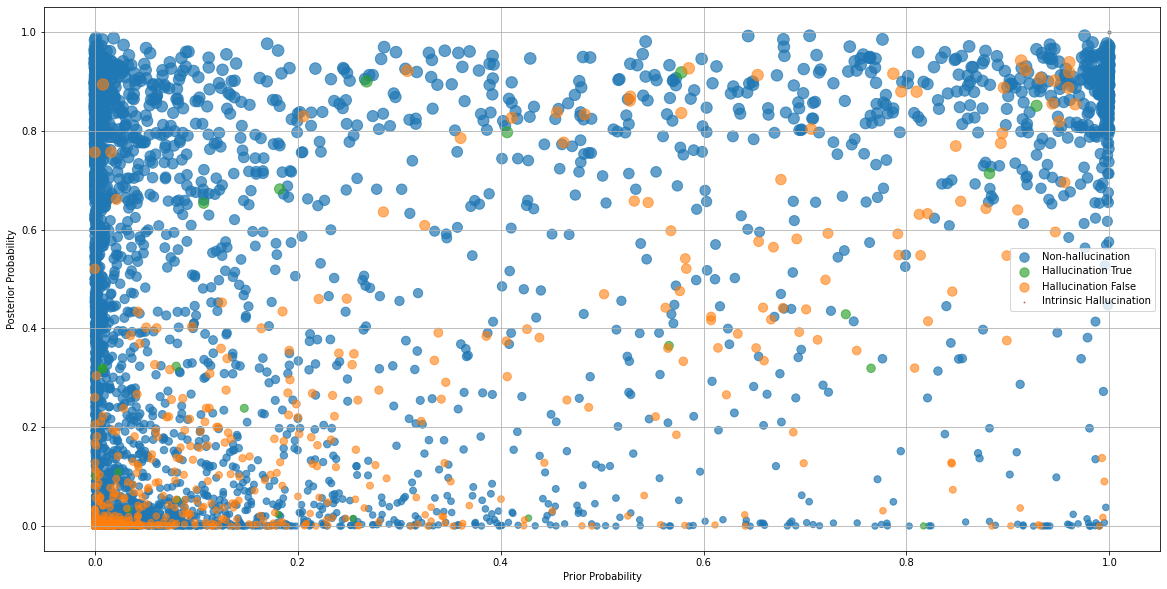

In [23]:
fig, ax = plt.subplots(figsize=(20.0, 10.0))
colors = ['tab:blue', 'tab:orange', 'tab:green']

no_hallucinated = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0]
hallucinated_true = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1]
hallucinated_false = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2]
hallucinated_intrinsic = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]

ax.scatter([i[0] for i in no_hallucinated], 
           [i[1] for i in no_hallucinated], c='tab:blue', s=[i[1]*100 + 40 for i in no_hallucinated], label='Non-hallucination', alpha=0.7)

ax.scatter([i[0] for i in hallucinated_true], 
           [i[1] for i in hallucinated_true], c='tab:green', s=[i[1]*100 + 40 for i in hallucinated_true], label='Hallucination True', alpha=0.65)

ax.scatter([i[0] for i in hallucinated_false], 
           [i[1] for i in hallucinated_false], c='tab:orange', s=[i[1]*100 + 40 for i in hallucinated_false], label='Hallucination False', alpha=0.6)

ax.scatter([i[0] for i in hallucinated_intrinsic], 
           [i[1] for i in hallucinated_intrinsic], c='tab:red', s=[i[1]*100 + 40 for i in hallucinated_intrinsic], label='Intrinsic Hallucination', alpha=0.6)

ax.scatter([1.0], [1.0], c='tab:gray', s=10)

ax.set_xlabel('Prior Probability')
ax.set_ylabel('Posterior Probability')
ax.legend()
ax.grid(True)

plt.show()

#### Overlap Baseline

In [24]:
from sklearn.metrics import classification_report

In [25]:
print(classification_report(factual_label, threshold_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1499    0.8798    0.2561       657
     Factual     0.9521    0.3238    0.4832      4849

    accuracy                         0.3901      5506
   macro avg     0.5510    0.6018    0.3697      5506
weighted avg     0.8564    0.3901    0.4561      5506



In [26]:
print(classification_report(factual_label, overlap_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.2037    0.6651    0.3119       657
     Factual     0.9345    0.6478    0.7652      4849

    accuracy                         0.6498      5506
   macro avg     0.5691    0.6565    0.5385      5506
weighted avg     0.8473    0.6498    0.7111      5506



In [27]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], overlap_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.2159    0.6652    0.3259       696
     Factual     0.9307    0.6503    0.7656      4810

    accuracy                         0.6522      5506
   macro avg     0.5733    0.6578    0.5458      5506
weighted avg     0.8403    0.6522    0.7101      5506



#### LM-based Baseline

In [28]:
print(classification_report(factual_label, posterior_label, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1703    0.6560    0.2704       657
     Factual     0.9240    0.5669    0.7027      4849

    accuracy                         0.5776      5506
   macro avg     0.5472    0.6115    0.4865      5506
weighted avg     0.8341    0.5776    0.6511      5506



In [29]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], posterior_label, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1786    0.6494    0.2801       696
     Factual     0.9180    0.5678    0.7016      4810

    accuracy                         0.5781      5506
   macro avg     0.5483    0.6086    0.4909      5506
weighted avg     0.8245    0.5781    0.6483      5506



#### Load KNN Model

In [30]:
import numpy as np
import pickle

In [99]:
# load the model from disk
knn_model = pickle.load(open('classifiers/knn_LM_factual_n5.pkl', 'rb'))

In [100]:
def predict(knn_model, posteriors, priors):
    posteriors = np.array(posteriors)
    priors = np.array(priors)

    x_mat = np.vstack([posteriors / np.std(posteriors), priors / np.std(priors)]).transpose()
#     x_mat = np.vstack([posteriors, priors]).transpose()

    return knn_model.predict(x_mat)

In [101]:
prediction = predict(knn_model, posterior_probs, prior_probs)

In [102]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], prediction, target_names=['Non-hallutionated', 'Hallutionated'], digits=4))

                   precision    recall  f1-score   support

Non-hallutionated     0.1415    0.2443    0.1792       696
    Hallutionated     0.8778    0.7857    0.8292      4810

         accuracy                         0.7172      5506
        macro avg     0.5097    0.5150    0.5042      5506
     weighted avg     0.7847    0.7172    0.7470      5506



In [103]:
# Hallunication:
# LM + KNN (n=3):
#                    precision    recall  f1-score   support

# Non-hallutionated     0.1404    0.3922    0.2068       696
#     Hallutionated     0.8812    0.6526    0.7499      4810

#          accuracy                         0.6197      5506
#         macro avg     0.5108    0.5224    0.4783      5506
#      weighted avg     0.7876    0.6197    0.6812      5506

In [104]:
print(classification_report(factual_label, prediction, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1332    0.2435    0.1722       657
     Factual     0.8846    0.7853    0.8320      4849

    accuracy                         0.7207      5506
   macro avg     0.5089    0.5144    0.5021      5506
weighted avg     0.7949    0.7207    0.7533      5506



In [105]:
# Factuality:
#
# Our model (n=5)
#               precision    recall  f1-score   support

#  Non-factual     0.1838    0.2907    0.2252       657
#      Factual     0.8957    0.8252    0.8590      4851

#     accuracy                         0.7614      5508
#    macro avg     0.5398    0.5580    0.5421      5508
# weighted avg     0.8108    0.7614    0.7834      5508


# Our model (n=6)
#               precision    recall  f1-score   support

#  Non-factual     0.1766    0.3942    0.2439       657
#      Factual     0.9015    0.7510    0.8194      4851

#     accuracy                         0.7084      5508
#    macro avg     0.5390    0.5726    0.5316      5508
# weighted avg     0.8150    0.7084    0.7507      5508

# LM + KNN, knn_LM_model (n=5)
#               precision    recall  f1-score   support

#  Non-factual     0.1332    0.2435    0.1722       657
#      Factual     0.8846    0.7853    0.8320      4849

#     accuracy                         0.7207      5506
#    macro avg     0.5089    0.5144    0.5021      5506
# weighted avg     0.7949    0.7207    0.7533      5506